# Prepare notebook

In [1]:
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from plotting_utilities import *

# Import data

In [2]:
books = pd.read_pickle('2019112_goodreads_book_data.pkl')
shelves = pd.read_pickle('2019112_goodreads_book_shelves.pkl')
books = books.join(shelves)

categories = pd.read_pickle('2019112_goodreads_book_categories.pkl')
category_mappings = json.load( open("category_mappings.json","r"))
#academic_fields = pd.read_pickle('2019112_goodreads_book_academic_fields.pkl')
#academic_field_mappings = json.load( open("academic_field_mappings.json","r"))

In [3]:
books.columns.tolist()

['Title',
 'Author',
 'My Rating',
 'Number of Pages',
 'Year Published',
 'Original Publication Year',
 'Date Added',
 'recommended',
 'goodreads_link',
 'goodreads_shelves',
 'goodreads_description',
 'goodreads_author_bio',
 'Publisher',
 '19th-century',
 'academic',
 'activism',
 'adult',
 'adventure',
 'africa',
 'african-american',
 'alcohol',
 'american',
 'american-history',
 'ancient',
 'ancient-history',
 'animals',
 'anthropology',
 'archaeology',
 'architecture',
 'art',
 'art-history',
 'arthurian',
 'artificial-intelligence',
 'asia',
 'astronomy',
 'atheism',
 'audiobook',
 'australia',
 'autobiography',
 'basketball',
 'biography',
 'biography-memoir',
 'biology',
 'birds',
 'book-club',
 'books-about-books',
 'brain',
 'british-literature',
 'buddhism',
 'buisness',
 'business',
 'canada',
 'cartography',
 'cats',
 'chapter-books',
 'chemistry',
 'childrens',
 'china',
 'christianity',
 'civil-war',
 'classic-literature',
 'classical-music',
 'classical-studies',
 'cla

In [4]:
len(books)

610

In [8]:
categories.loc.sum().sort_values()

technology      13
mythology       19
culinary        20
literatures     23
travel          92
other           95
philosophy      99
health         111
culture        141
biography      159
sociology      202
history        235
sciences       302
dtype: int64

# Initial exploration of the data

In [9]:
books['Date Added'] = pd.to_datetime(books['Date Added'])
books['Year Added'] = books['Date Added'].dt.year


In [10]:
books.groupby('Year Added')['Title'].count()

Year Added
2018    435
2019    175
Name: Title, dtype: int64

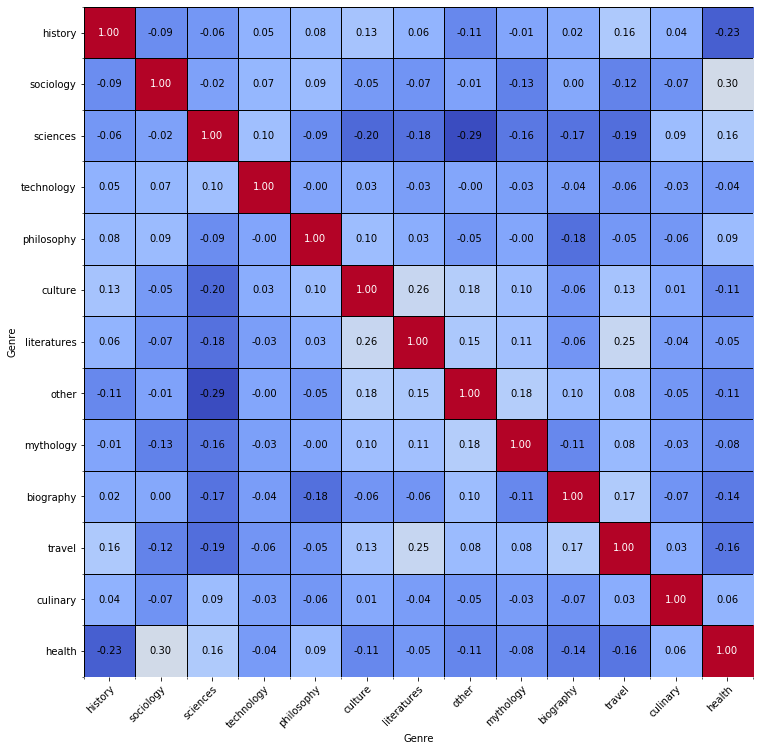

In [22]:
fig, ax = plt.subplots(1,1, figsize = (15,15))
im, cbar = heatmap(categories.corr(), 
                   row_title = 'Genre', row_labels= categories.columns, 
                   col_title = 'Genre', col_labels = categories.columns,
                   ax=ax, cmap='coolwarm', cbarlabel="Correlation", vmin = -1, vmax =1, 
                   x_tick_rotation = 45)
cbar.remove()
cmv = im.get_array().data
texts = annotate_heatmap(im, data = cmv, valfmt="{x:.2f}")
plt.savefig('Category correlations',bbox_inches='tight',pad_inches=1., dpi=300)

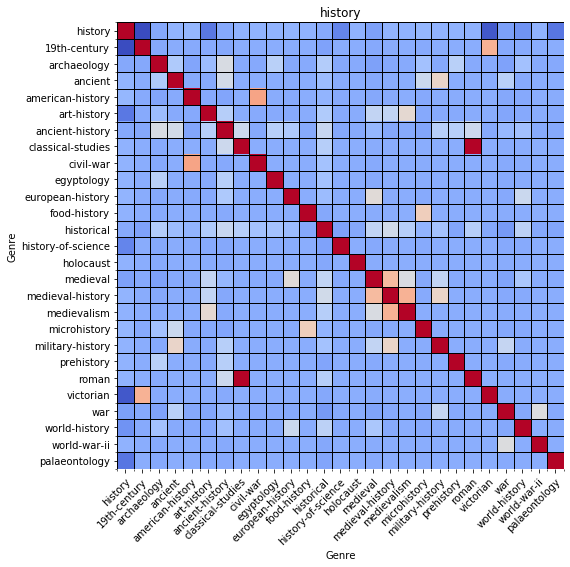

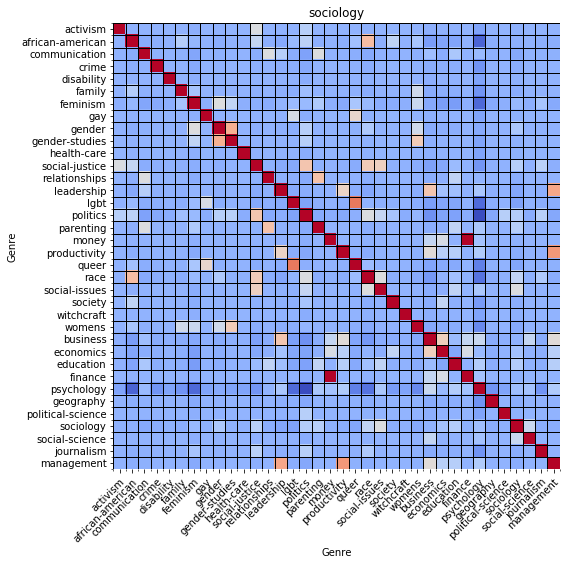

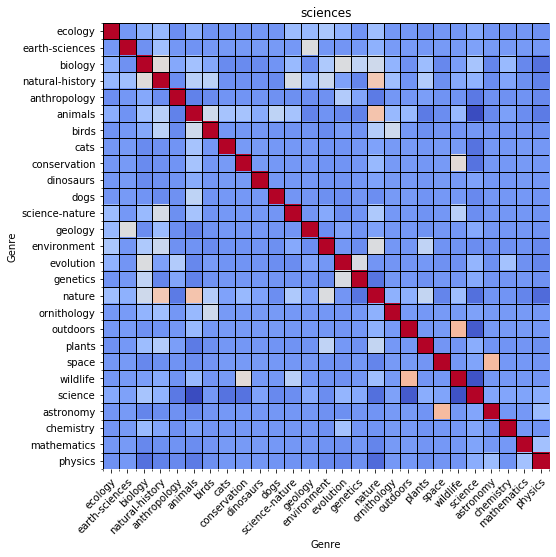

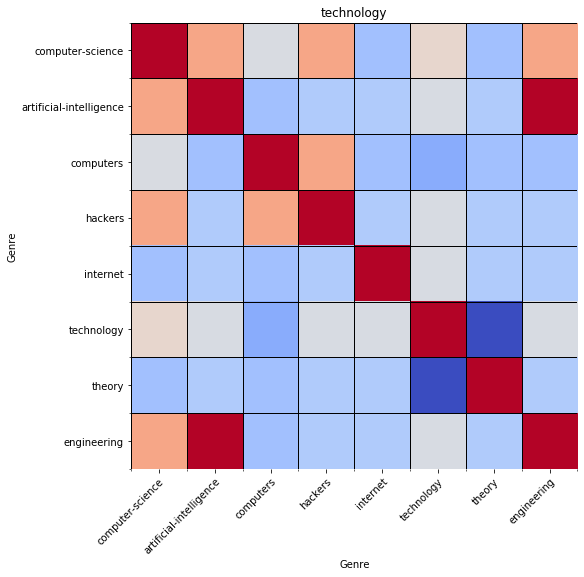

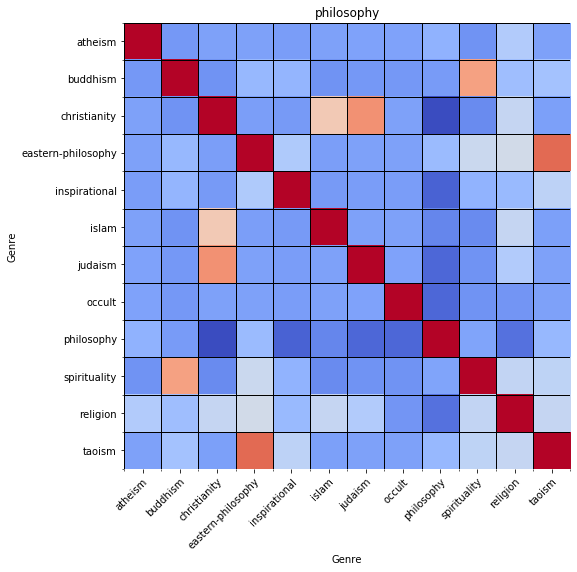

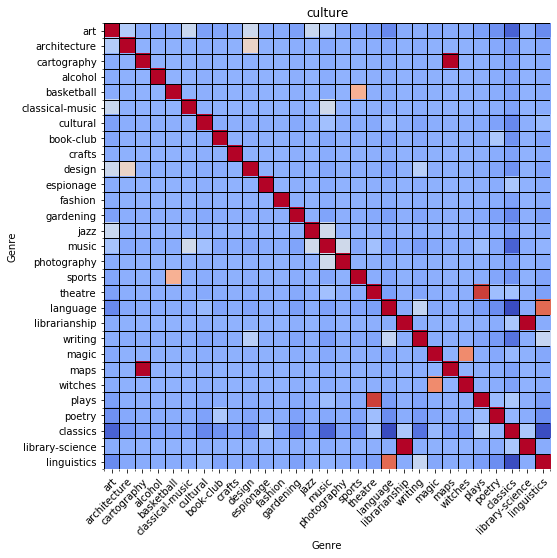

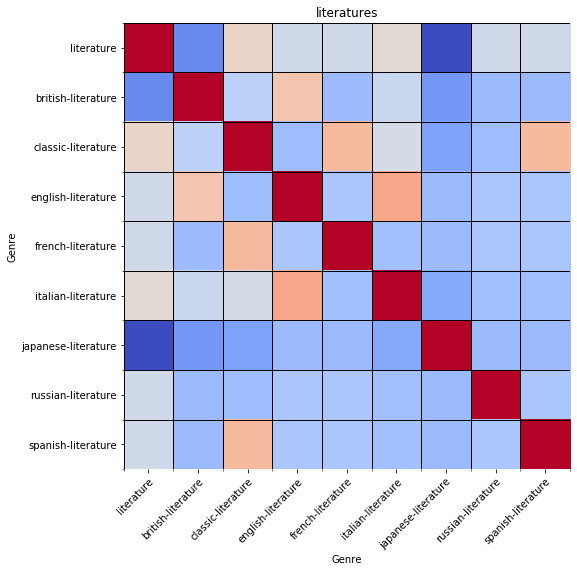

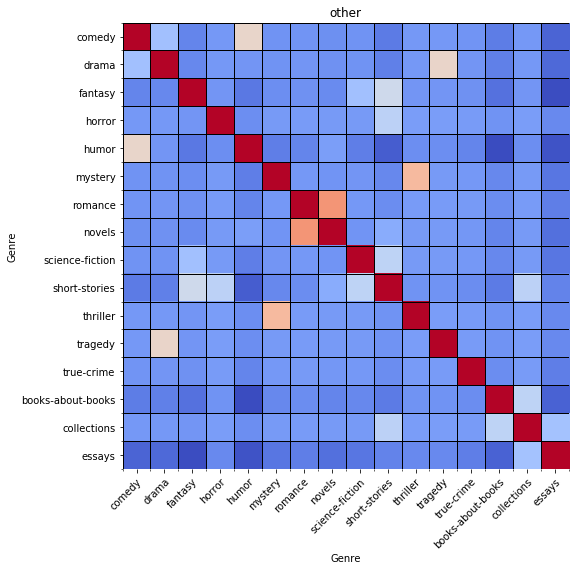

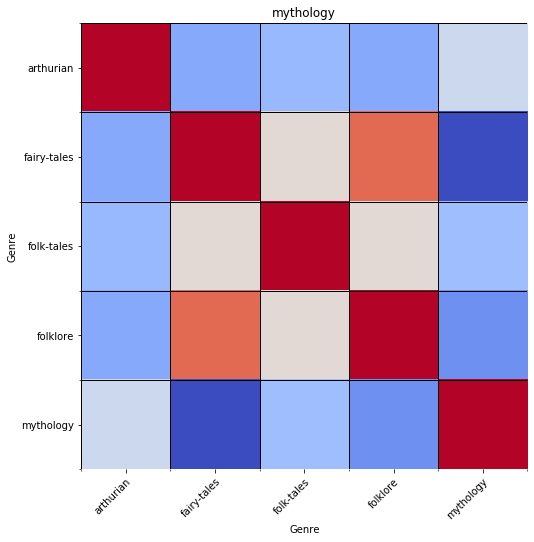

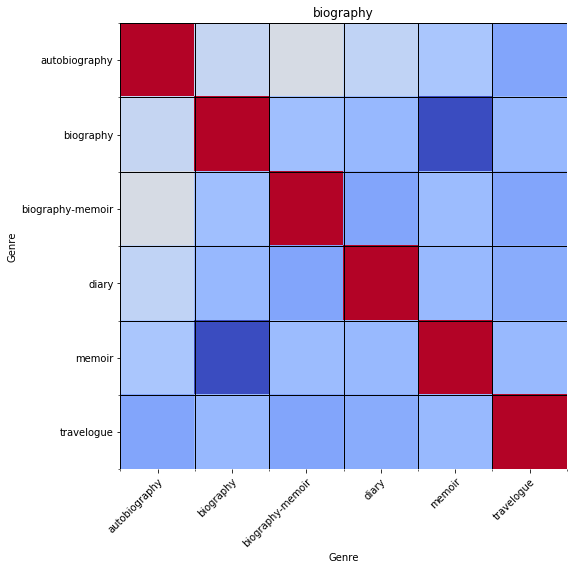

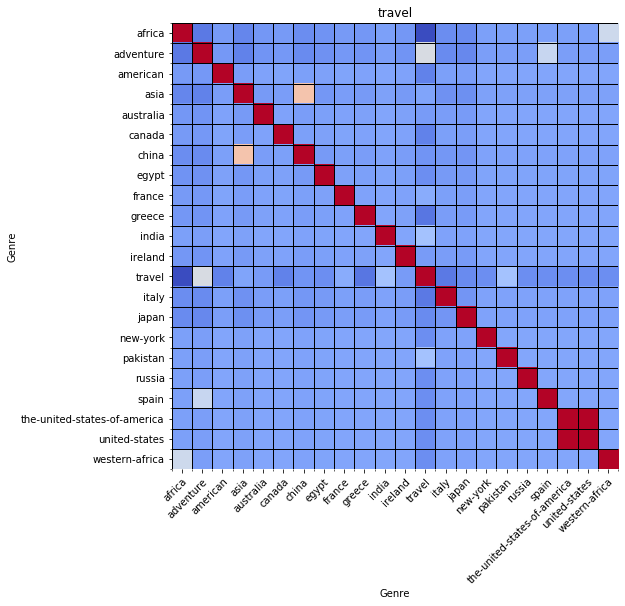

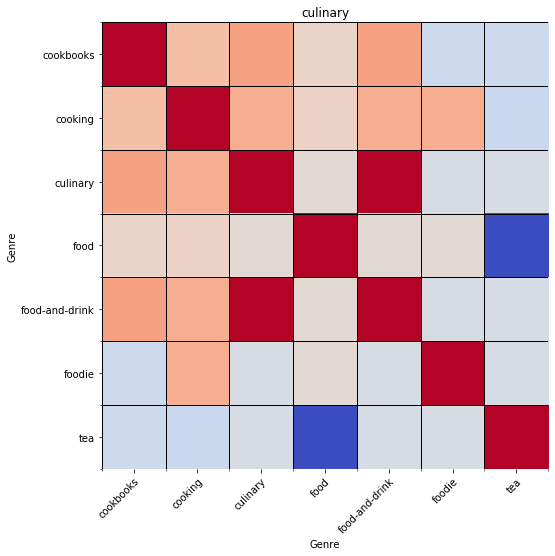

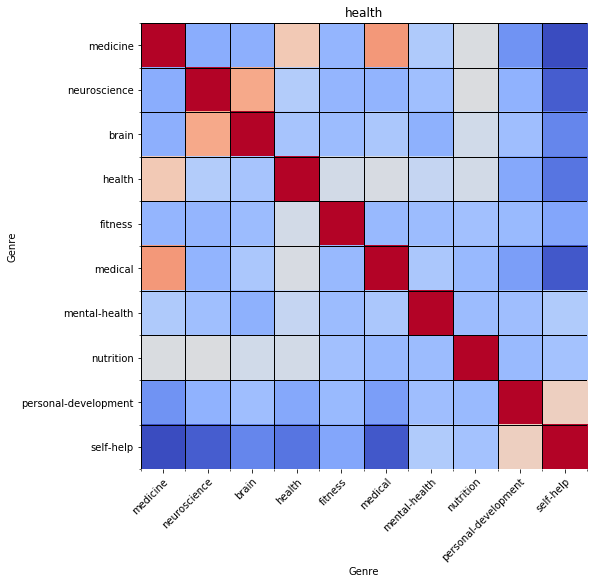

In [23]:
for k,v in category_mappings.items():
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    g = books.loc[categories[k], v]
    ax.set_title(k)
    im, cbar = heatmap(g.astype(int).corr(), 
                   row_title = 'Genre', row_labels= g.columns, 
                   col_title = 'Genre', col_labels = g.columns,
                   ax=ax, cmap='coolwarm', cbarlabel="Correlation", vmin = -1, vmax =1, 
                   x_tick_rotation = 45)
    cbar.remove()
    #cmv = im.get_array().data
    #texts = annotate_heatmap(im, data = cmv, valfmt="{x:.2f}")  

In [13]:
counts = {}
normalized_counts = {}
for c in categories.columns:
    ratings = books.loc[categories[c], 'My Rating']
    counts[c] = ratings.value_counts().to_dict()
    normalized_counts[c] = ratings.value_counts(normalize=True).to_dict()


In [25]:
{k:v[4]+v[5] for k, v in normalized_counts.items()}

{'history': 0.3702127659574468,
 'sociology': 0.4504950495049505,
 'sciences': 0.46688741721854304,
 'technology': 0.46153846153846156,
 'philosophy': 0.33333333333333337,
 'culture': 0.3971631205673759,
 'literatures': 0.17391304347826086,
 'other': 0.27368421052631575,
 'mythology': 0.21052631578947367,
 'biography': 0.35220125786163525,
 'travel': 0.32608695652173914,
 'culinary': 0.5,
 'health': 0.45945945945945943}

In [6]:
totals = (pd.DataFrame(counts).T).sum(axis = 1)

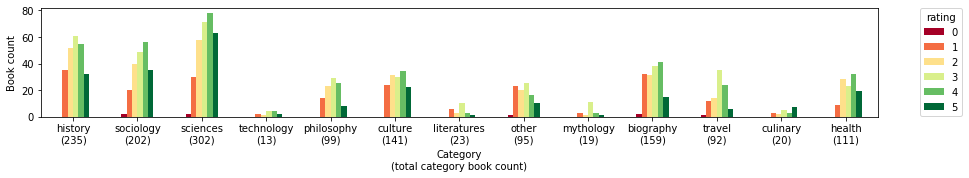

In [10]:
fig, ax = plt.subplots(1,1, figsize = (15,2))
(pd.DataFrame(counts).T).sort_index(axis =1).plot.bar(cmap = 'RdYlGn',ax =ax)
plt.legend(title = 'rating', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xticklabels(['%s\n(%d)'%(i,c) for i,c in totals.iteritems()], rotation = 0);
ax.set_xlabel('Category\n(total category book count)');
ax.set_ylabel('Book count');
plt.savefig('Category rating counts',bbox_inches='tight',pad_inches=1., dpi=300)

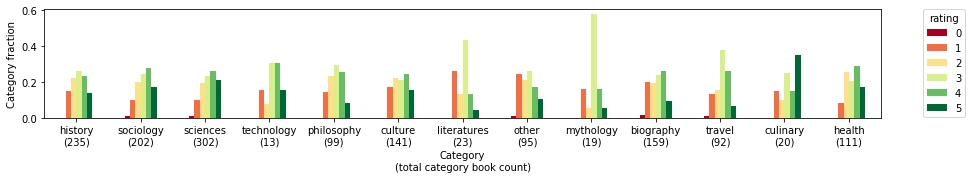

In [11]:
fig, ax = plt.subplots(1,1, figsize = (15,2))
(pd.DataFrame(normalized_counts).T).sort_index(axis =1).plot.bar(cmap = 'RdYlGn',ax =ax)
plt.legend(title = 'rating', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xticklabels(['%s\n(%d)'%(i,c) for i,c in totals.iteritems()], rotation = 0);
ax.set_xlabel('Category\n(total category book count)');
ax.set_ylabel('Category fraction');
plt.savefig('Category rating distributions',bbox_inches='tight',pad_inches=1., dpi=300)

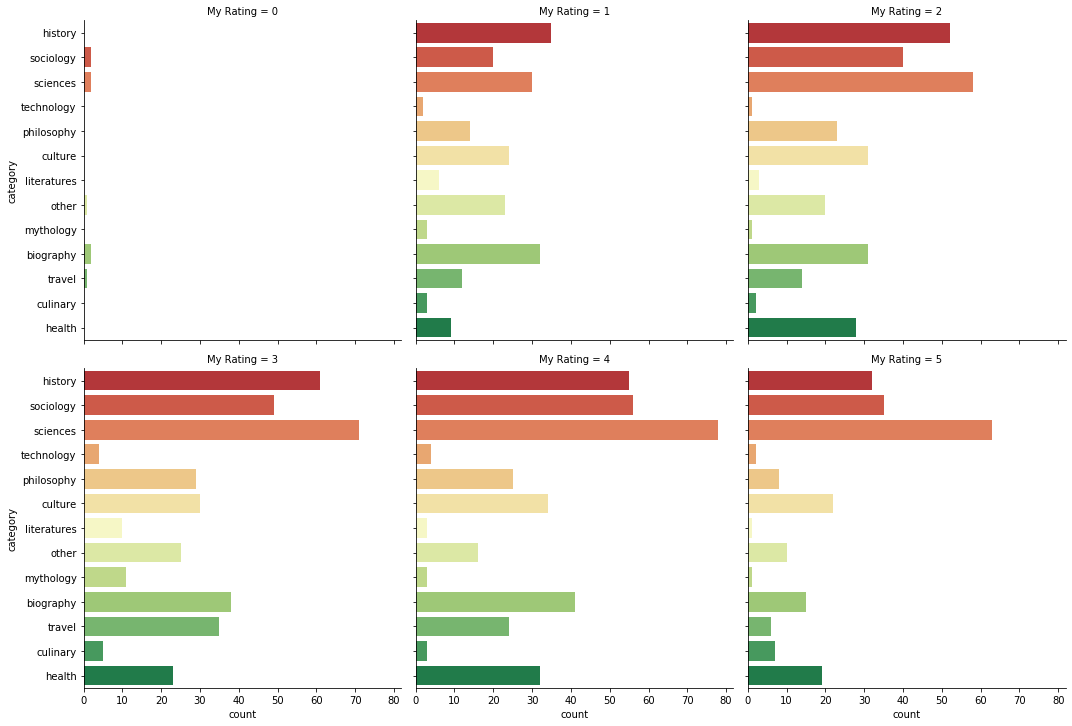

In [15]:
sns.catplot(data = pd.melt(categories.reset_index(), id_vars = ['index'], var_name = 'category')\
                .replace(False, np.nan).dropna(subset = ['value']).fillna(0)\
                .merge(books.reset_index()[['index', 'My Rating']], on = 'index', how = 'left'),
                col ='My Rating', y = 'category', kind = 'count', palette = 'RdYlGn', col_wrap = 3)
